In [1]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [2]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (14,7))
    
    y_limits = (Y_real.min(), Y_real.max())
    plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2.5, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r.-", linewidth=2.3, label="Predicción")
    plt.legend(loc = 1, fontsize=20)   
    plt.xlabel("Tiempo (1 h)", fontsize=20) 
    plt.ylabel("Consumo (normalizado)", fontsize=20)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Entrenamiento")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validación")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, batch_size, errores, figure_size = (12,6.75), savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = figure_size)

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
       
   
    plt.title("Entrenamiento: "+("{:.4e}".format(errores[0]))+", Validación: "+("{:.4e}".format(errores[-1])),
              fontsize=18)
    plt.plot(train_errors,  "b.-", linewidth=2, label="Entrenamiento"), # color = "darkorange",
    plt.plot(val_errors, "r.-", linewidth=2, label="Validación")
    plt.legend(loc = 1, fontsize=20)   
    plt.xlabel("Tamaño del conjunto de entrenamiento / "+str(batch_size), fontsize=20) 
    plt.ylabel("mse", fontsize=20)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def ts_learning_curves(model, X_train, Y_train, X_val, Y_val, batch = 1):
    
    # Esta función ENTRENA un modelo de ML y muestra sus Learning curves.
        
    train_errors, val_errors = [], []
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    
    start_time = time.time()
    
    iteraciones = Y_train.shape[0]
    
    for i in range(0, iteraciones, batch):
        
        index = i+1    
        if (index + 1) > iteraciones:
            break
            
        X_train_slice, Y_train_slice = X_train[:index], Y_train[:index]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
        
        current_time = time.time()
    
        if i%100 == 0: # Notificación para ver cuánto tiempo de entrenamiento lleva, y cuánto queda.
            print("training: "+str(i)+" of "+str(iteraciones), "current time: "+str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
    

        
    print("tiempo de ejecución: "+str(execution_time)+" s")
    
    history = pd.DataFrame()
    history["loss"] = train_errors
    history["val_loss"] = val_errors
    
    return history


# Importo los datos

In [3]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [4]:
# Selecciono las columnas para one step forecasting

df_train = df_train.iloc[:,:-23].dropna()
df_test = df_test.iloc[:,:-23].dropna()

X_Y_train = df_train.to_numpy()

X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-1]
Y_test = X_Y_test[:,-1]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-1], X_Y_train[:,-1],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

#  --> Ahora, incluyo el análisis exporatorio hecho en el X_train, Y_train únicamente !!!


# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)


X_train = X_Y_train[:,:-1]
Y_train = X_Y_train[:,-1]

X_val = X_Y_val[:,:-1]
Y_val = X_Y_val[:,-1]

X_test = X_Y_test[:,:-1]
Y_test = X_Y_test[:,-1]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

print(X_train[0], Y_train[0], X_val[0], Y_val[0]) # Compruebo que está estandarizdo

(21037, 14) (21037,) (7013, 14) (7013,) (7012, 14) (7012,)
[0.44065198 0.36477505 1.         0.19080256 0.54194047 0.00691683
 0.17962843 0.         1.         0.18833984 1.         0.74444444
 1.         0.31966571] 0.2760076608339863 [0.5795207  0.37070102 0.52173913 0.         0.48115578 0.76621131
 0.27894794 0.         0.         0.24653229 0.         0.41111111
 0.57       0.64203012] 0.6081657525898843


In [5]:
np.concatenate((X_train, X_val), axis = 0)[21037,:]

array([0.5795207 , 0.37070102, 0.52173913, 0.        , 0.48115578,
       0.76621131, 0.27894794, 0.        , 0.        , 0.24653229,
       0.        , 0.41111111, 0.57      , 0.64203012])

In [6]:
# Modelos de base & tabla de errores

# mi modelo de base va a ser naive forecasting. "El consumo de ahora es el mismo que el del instante anterior"

# función auxiliar

def baseline_model_1(samples, previous_sample=1): # cualquier instante anterior
    
    # Samples es un dataframe con los targets
    # previous_sample es la muestra anterior que queremos que se devuelva
    
    df = pd.DataFrame(data = samples, columns = ["real"])
    if previous_sample > samples.size:
        return ("No hay instantes anteriores a t-"+str(previous_sample))
    
    df["naive_1h"] = df["real"].shift(previous_sample)
    
    return df.dropna()


# Creo la predicción del modelo naive en los tres sets

# train, val, test
name = "naive_1h"
naive_train = baseline_model_1(Y_train, previous_sample=1)
naive_val = baseline_model_1(Y_val, previous_sample=1)
naive_test = baseline_model_1(Y_test, previous_sample=1)

# creo un dataframe para guardar los errores
from sklearn.metrics import mean_squared_error, r2_score

RESULTADOS = pd.DataFrame() 

RESULTADOS.loc[name, "train 1 mse"]             = mean_squared_error(naive_train.iloc[:,0], naive_train.iloc[:,-1])
RESULTADOS.loc[name, "val mse"]                 = mean_squared_error(naive_val.iloc[:,0], naive_val.iloc[:,-1])
RESULTADOS.loc[name, "train 2 mse"]             = None
RESULTADOS.loc[name, "test mse"]                = mean_squared_error(naive_test.iloc[:,0], naive_test.iloc[:,-1])

RESULTADOS.loc[name, "test R^2"]                = r2_score(naive_test.iloc[:,0], naive_test.iloc[:,-1])

RESULTADOS.loc[name, "delta train 1 and val"]   = 0
                                        
RESULTADOS.loc[name, "delta train 2 and test"]  = 0


RESULTADOS.loc[name, "training 1 time (s)"]             = 0
RESULTADOS.loc[name, "train 1 prediction time (s)"]     = 0
RESULTADOS.loc[name, "val prediction time (s)"]         = 0

RESULTADOS.loc[name, "training 2 time (s)"]             = 0
RESULTADOS.loc[name, "train 2 prediction time (s)"]     = 0
RESULTADOS.loc[name, "test prediction time (s)"]        = 0

RESULTADOS.loc[name, "# params"]                        = 0

RESULTADOS.loc[name, "Complexity"]                      = 0

pd.options.display.float_format = '{:.3e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")

In [7]:
def calcular_datos_ML(modelo, train, val, test, resultados_df, name = "modelo",
                      n_params = np.nan, complexity = None):

    # train, val, test son tuplas del estilo: train =  (X_train, Y_train)
    # resultados es un dataframe
    ##########################################################################
    
    # Trabajo sólo en TRAIN + VAL
    
    # 1. Entreno los modelos en train
    train_1_start = time.time()
    modelo.fit(train[0], train[-1])
    train_1_time = time.time() - train_1_start
    
    # 2. Hago las predicciones en train
    train_1_predict_start = time.time()
    Y_train_1_predicted     = modelo.predict(train[0])
    train_1_predict_time  = time.time() - train_1_predict_start
    
    # 3. Hago las predicciones en val
    val_predict_start = time.time()
    Y_val_predicted   = modelo.predict(val[0])
    val_predict_time  = time.time() - val_predict_start
    
    
    # Trabajo en el dataset ENTERO
    
    # 1. Concateno X_train y X_val para crear un nuevo X_train, e ídem con Y_train
    
    X_train = np.concatenate((train[0], val[0]), axis = 0)
    Y_train = np.concatenate((train[-1], val[-1]), axis = 0)
    
    # 2. Entreno los modelos en train total
    train_2_start = time.time()
    modelo.fit(X_train, Y_train)
    train_2_time  = time.time() - train_2_start
    
    # 3. Hago las predicciones en train
    train_2_predict_start = time.time()
    Y_train_2_predicted   = modelo.predict(X_train)
    train_2_predict_time  = time.time() - train_2_predict_start
    
    # 4. Hago las predicciones en test
    test_predict_start = time.time()
    Y_test_predicted   = modelo.predict(test[0])
    test_predict_time  = time.time() - test_predict_start
    
    
    # CÁLCULO DE ERRORES Y DURACIONES
    
    
    # MSE:
    resultados_df.loc[name, "train 1 mse"]             = mean_squared_error(train[-1], Y_train_1_predicted)
    resultados_df.loc[name, "val mse"]                 = mean_squared_error(val[-1], Y_val_predicted)
    resultados_df.loc[name, "train 2 mse"]             = mean_squared_error(Y_train, Y_train_2_predicted)
    resultados_df.loc[name, "test mse"]                = mean_squared_error(test[-1], Y_test_predicted)
    
    # R^2:
    resultados_df.loc[name, "test R^2"]                = r2_score(test[-1], Y_test_predicted)
    
    # Deltas
    resultados_df.loc[name, "delta train 1 and val"]   = np.abs(resultados_df.loc[name, "train 1 mse"] - 
                                                               resultados_df.loc[name, "val mse"])
    resultados_df.loc[name, "delta train 2 and test"]  = np.abs(resultados_df.loc[name, "train 2 mse"] - 
                                                               resultados_df.loc[name, "test mse"])
    # Duraciones (s)
    
    resultados_df.loc[name, "training 1 time (s)"]             = train_1_time
    resultados_df.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
    resultados_df.loc[name, "val prediction time (s)"]         = val_predict_time
    
    resultados_df.loc[name, "training 2 time (s)"]             = train_2_time
    resultados_df.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
    resultados_df.loc[name, "test prediction time (s)"]        = test_predict_time
    
    # Parámeros
    
    resultados_df.loc[name, "# params"]                        = n_params
    
    # Complejidad
    
    resultados_df.loc[name, "Complexity"]                      = complexity
    

    resultados_df.sort_values(by = ["test mse"])

    return resultados_df, Y_train_1_predicted, Y_val_predicted, Y_train_2_predicted, Y_test_predicted

## Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs = -1)

RESULTADOS, Y_train_1_lr, Y_val_lr, Y_train_2_lr, Y_test_lr = calcular_datos_ML(lr, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "lr",
                                                                                n_params = 15)

## Decision Trees

In [9]:
from sklearn.tree import DecisionTreeRegressor

dt1 = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                           max_features=None, random_state = 42, max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, ccp_alpha=0.0)

dt2 = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth = 8,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                           max_features=None, random_state = 42, max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, ccp_alpha=0.0)

dt3 = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth = 10,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                           max_features=None, random_state = 42, max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, ccp_alpha=0.0)


RESULTADOS, Y_train_1_dt1, Y_val_dt1, Y_train_2_dt1, Y_test_dt1 = calcular_datos_ML(dt1, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "dt1",
                                                                                n_params = None,
                                                                                complexity = "30")

RESULTADOS, Y_train_1_dt2, Y_val_dt2, Y_train_2_dt1, Y_test_dt2 = calcular_datos_ML(dt2, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "dt2",
                                                                                n_params = None,
                                                                                complexity = "8")

RESULTADOS, Y_train_1_dt3, Y_val_dt3, Y_train_2_dt3, Y_test_dt3 = calcular_datos_ML(dt3, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "dt3",
                                                                                n_params = np.nan,
                                                                                complexity = "10")

In [14]:
dt3.get_depth()

10

## Decsion Tree Ensembles 

In [98]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost

rfr = RandomForestRegressor(n_estimators = 10, criterion='mse', max_depth = 10,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs = -1,
                            random_state = 42, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

xgb = xgboost.XGBRegressor(n_estimators = 10, max_depth = 8, random_state = 42, n_jobs = -1)

etr = ExtraTreesRegressor(n_estimators = 10, criterion='mse', max_depth = 10, min_samples_split=2,
                          min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                          max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                          bootstrap=False, oob_score=False, n_jobs = -1, random_state = 42, verbose=0,
                          warm_start=False, ccp_alpha=0.0, max_samples=None)

RESULTADOS, Y_train_1_rfr, Y_val_rfr, Y_train_2_rfr, Y_test_rfr = calcular_datos_ML(rfr, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "rfr",
                                                                                n_params = None,
                                                                                complexity = "(10, 10)")

RESULTADOS, Y_train_1_xgb, Y_val_xgb, Y_train_2_xgb, Y_test_xgb = calcular_datos_ML(xgb, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "xgb",
                                                                                n_params = None,
                                                                                complexity = "(10, 10)")

RESULTADOS, Y_train_1_etr, Y_val_etr, Y_train_2_etr, Y_test_etr = calcular_datos_ML(etr, (X_train, Y_train),
                                                                                (X_val, Y_val), (X_test, Y_test),
                                                                                RESULTADOS, name = "etr",
                                                                                n_params = None,
                                                                                complexity = "(10, 10)")



In [99]:
RESULTADOS.sort_values(by = ["training 2 time (s)"])

,train 1 mse,val mse,train 2 mse,test mse,test R^2,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
naive_1h,3.971e-03,3.773e-03,nan,3.706e-03,9.042e-01,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
lr,2.911e-03,2.702e-03,2.858e-03,2.614e-03,9.324e-01,2.097e-04,2.433e-04,1.047e-02,3.045e-03,8.638e-04,1.727e-02,1.138e-03,6.313e-04,1.500e+01,NaN
etr,1.052e-03,1.163e-03,1.079e-03,1.094e-03,9.717e-01,1.113e-04,1.520e-05,1.149e-01,1.055e-01,1.049e-01,1.139e-01,1.052e-01,1.044e-01,nan,"(10, 10)"
dt2,1.078e-03,1.348e-03,1.082e-03,1.193e-03,9.692e-01,2.705e-04,1.107e-04,1.582e-01,2.184e-03,9.212e-04,2.102e-01,2.909e-03,9.279e-04,nan,8
dt3,6.821e-04,1.307e-03,7.178e-04,1.074e-03,9.722e-01,6.253e-04,3.563e-04,1.939e-01,2.635e-03,1.071e-03,2.582e-01,3.570e-03,1.064e-03,nan,10
xgb,5.863e-04,8.990e-04,6.250e-04,8.207e-04,9.788e-01,3.127e-04,1.957e-04,2.266e-01,7.170e-03,2.777e-03,2.948e-01,8.527e-03,1.977e-03,nan,"(10, 10)"
rfr,5.989e-04,8.827e-04,6.268e-04,8.360e-04,9.784e-01,2.838e-04,2.092e-04,3.176e-01,1.057e-01,1.047e-01,3.161e-01,1.062e-01,1.048e-01,nan,"(10, 10)"
dt1,0.000e+00,1.807e-03,0.000e+00,1.772e-03,9.542e-01,1.807e-03,1.772e-03,3.427e-01,5.930e-03,1.926e-03,4.375e-01,8.217e-03,2.104e-03,nan,30


# Redes Neuronales

## Preparo los datos

In [58]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())


# Selecciono las columnas para one step forecasting

df_train = df_train.iloc[:,:-24].dropna()
df_test = df_test.iloc[:,:-24].dropna()

X_Y_train = df_train.to_numpy()

X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:]
Y_test = X_Y_test[:,-1]

# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:], X_Y_train[:,-1],
                                                  test_size = 0.25, random_state = 42, shuffle = False)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)

# Lo convierto en un problema de ML

win_len = 1             # Intento predecir el siguiente instante en el consumo con 1 h de antelación
tamaño_del_batch = 256
number_of_features = 14

X_train_val = np.concatenate((X_Y_train[:,:-1], X_Y_val[:,:-1]), axis = 0)
Y_train_val = np.concatenate((X_Y_train[:,-1], X_Y_val[:,-1]), axis = 0)

# series

train_ts_generator = TimeseriesGenerator(X_Y_train[:,:-1], X_Y_train[:,-1], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = 1)

val_ts_generator = TimeseriesGenerator(X_Y_val[:,:-1], X_Y_val[:,-1], length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = 1)

train_and_val_ts_generator = TimeseriesGenerator(X_train_val, Y_train_val, length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = 1)

test_ts_generator = TimeseriesGenerator(X_Y_test[:,:-1], X_Y_test[:,-1], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = 1)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(Y_train_val.shape, train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

In [59]:
resultados_df = pd.DataFrame()

In [60]:
from keras.models import load_model
from keras.utils.layer_utils import count_params

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

dnn = keras.models.Sequential([
    keras.layers.Input((win_len, number_of_features)),
    keras.layers.Dense(24, activation = "relu"),
    keras.layers.Dense(1, activation = "relu")                                                      
])

early_stopping = keras.callbacks.EarlyStopping(patience = 5)

dnn.compile(loss = "mse", optimizer = "adam")  

modelo = dnn
name = "dnn"

# 1. Entreno los modelos en train
train_1_start = time.time()
dnn.fit(train_ts_generator, epochs = 500, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping])
train_1_time = time.time() - train_1_start

# 2. Hago las predicciones en train
train_1_predict_start = time.time()
Y_train_1_predicted     = dnn.predict(train_ts_generator).flatten()
train_1_predict_time  = time.time() - train_1_predict_start

# 3. Hago las predicciones en val
val_predict_start = time.time()
Y_val_predicted   = dnn.predict(val_ts_generator).flatten()
val_predict_time  = time.time() - val_predict_start


# Trabajo en el dataset ENTERO, uso train_and_val_ts_generator

# 2. Entreno los modelos en train total
train_2_start = time.time()
dnn.fit(train_and_val_ts_generator, epochs = 500, validation_data = test_ts_generator, shuffle = False,
                         callbacks = [early_stopping])
train_2_time  = time.time() - train_2_start

# 3. Hago las predicciones en train
train_2_predict_start = time.time()
Y_train_2_predicted   = dnn.predict(train_and_val_ts_generator).flatten()
train_2_predict_time  = time.time() - train_2_predict_start

# 4. Hago las predicciones en test
test_predict_start = time.time()
Y_test_predicted   = dnn.predict(test_ts_generator).flatten()
test_predict_time  = time.time() - test_predict_start


# CÁLCULO DE ERRORES Y DURACIONES

modelo = dnn

# MSE:
resultados_df.loc[name, "train 1 mse"]             = modelo.evaluate(train_ts_generator)
resultados_df.loc[name, "val mse"]                 = modelo.evaluate(val_ts_generator)
resultados_df.loc[name, "train 2 mse"]             = modelo.evaluate(train_and_val_ts_generator)
resultados_df.loc[name, "test mse"]                = modelo.evaluate(test_ts_generator)

# R^2:
#resultados_df.loc[name, "test R^2"]                = r2_score(, Y_test_predicted)

# Deltas
resultados_df.loc[name, "delta train 1 and val"]   = np.abs(resultados_df.loc[name, "train 1 mse"] - 
                                                           resultados_df.loc[name, "val mse"])
resultados_df.loc[name, "delta train 2 and test"]  = np.abs(resultados_df.loc[name, "train 2 mse"] - 
                                                           resultados_df.loc[name, "test mse"])
# Duraciones (s)

resultados_df.loc[name, "training 1 time (s)"]             = train_1_time
resultados_df.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
resultados_df.loc[name, "val prediction time (s)"]         = val_predict_time

resultados_df.loc[name, "training 2 time (s)"]             = train_2_time
resultados_df.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
resultados_df.loc[name, "test prediction time (s)"]        = test_predict_time

# Parámeros

resultados_df.loc[name, "# params"]                        = count_params(modelo.trainable_weights)

# Complejidad

resultados_df.loc[name, "Complexity"]                      = None


resultados_df.sort_values(by = ["test mse"])

Epoch 1/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/

Epoch 5/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 13/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 14/500
110/110 [==============================] - 0s 2ms/step - loss: 0.0015 - va

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
dnn,1.439e-03,1.236e-03,1.388e-03,1.384e-03,2.027e-04,3.377e-06,1.892e+01,2.439e-01,8.895e-02,2.460e+01,2.260e-01,8.818e-02,3.850e+02,nan


In [66]:
np.random.seed(42)
tf.random.set_seed(42)

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(number_of_features, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(10, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(10, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(7, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.SimpleRNN(1, activation = "relu")
])


rnn.compile(loss = "mse", optimizer = "adam")


modelo = rnn
name = "rnn"

# 1. Entreno los modelos en train
train_1_start = time.time()
rnn.fit(train_ts_generator, epochs = 600, validation_data = val_ts_generator, shuffle = False)
train_1_time = time.time() - train_1_start

# 2. Hago las predicciones en train
train_1_predict_start = time.time()
Y_train_1_predicted     = rnn.predict(train_ts_generator).flatten()
train_1_predict_time  = time.time() - train_1_predict_start

# 3. Hago las predicciones en val
val_predict_start = time.time()
Y_val_predicted   = rnn.predict(val_ts_generator).flatten()
val_predict_time  = time.time() - val_predict_start


# Trabajo en el dataset ENTERO, uso train_and_val_ts_generator

# 2. Entreno los modelos en train total
train_2_start = time.time()
rnn.fit(train_and_val_ts_generator, epochs = 600, validation_data = test_ts_generator, shuffle = False)
train_2_time  = time.time() - train_2_start

# 3. Hago las predicciones en train
train_2_predict_start = time.time()
Y_train_2_predicted   = rnn.predict(train_and_val_ts_generator).flatten()
train_2_predict_time  = time.time() - train_2_predict_start

# 4. Hago las predicciones en test
test_predict_start = time.time()
Y_test_predicted   = rnn.predict(test_ts_generator).flatten()
test_predict_time  = time.time() - test_predict_start


# CÁLCULO DE ERRORES Y DURACIONES

modelo = rnn

# MSE:
resultados_df.loc[name, "train 1 mse"]             = modelo.evaluate(train_ts_generator)
resultados_df.loc[name, "val mse"]                 = modelo.evaluate(val_ts_generator)
resultados_df.loc[name, "train 2 mse"]             = modelo.evaluate(train_and_val_ts_generator)
resultados_df.loc[name, "test mse"]                = modelo.evaluate(test_ts_generator)

# R^2:
#resultados_df.loc[name, "test R^2"]                = r2_score(, Y_test_predicted)

# Deltas
resultados_df.loc[name, "delta train 1 and val"]   = np.abs(resultados_df.loc[name, "train 1 mse"] - 
                                                           resultados_df.loc[name, "val mse"])
resultados_df.loc[name, "delta train 2 and test"]  = np.abs(resultados_df.loc[name, "train 2 mse"] - 
                                                           resultados_df.loc[name, "test mse"])
# Duraciones (s)

resultados_df.loc[name, "training 1 time (s)"]             = train_1_time
resultados_df.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
resultados_df.loc[name, "val prediction time (s)"]         = val_predict_time

resultados_df.loc[name, "training 2 time (s)"]             = train_2_time
resultados_df.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
resultados_df.loc[name, "test prediction time (s)"]        = test_predict_time

# Parámeros

resultados_df.loc[name, "# params"]                        = count_params(modelo.trainable_weights)

# Complejidad

resultados_df.loc[name, "Complexity"]                      = None


resultados_df.sort_values(by = ["test mse"])

Epoch 1/600
83/83 [==============================] - 1s 10ms/step - loss: 0.0798 - val_loss: 0.0288
Epoch 2/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0237 - val_loss: 0.0155
Epoch 3/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0100
Epoch 4/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 5/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 6/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 7/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 8/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 9/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 10/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 11

83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 84/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 85/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 86/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 87/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 88/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 89/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 90/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 91/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 92/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 93/600


83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8606e-04
Epoch 245/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8572e-04
Epoch 246/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8646e-04
Epoch 247/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8599e-04
Epoch 248/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8568e-04
Epoch 249/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8452e-04
Epoch 250/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8328e-04
Epoch 251/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8284e-04
Epoch 252/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.8209e-04
Epoch 253/600
83/83 [==============================] - 0s 4ms/step - 

83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0495e-04
Epoch 401/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0536e-04
Epoch 402/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0357e-04
Epoch 403/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0442e-04
Epoch 404/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0436e-04
Epoch 405/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0429e-04
Epoch 406/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0370e-04
Epoch 407/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0370e-04
Epoch 408/600
83/83 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.0345e-04
Epoch 409/600
83/83 [==============================] - 0s 4ms/step - 

83/83 [==============================] - 0s 4ms/step - loss: 9.9440e-04 - val_loss: 8.7986e-04
Epoch 556/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9547e-04 - val_loss: 8.7981e-04
Epoch 557/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9402e-04 - val_loss: 8.7964e-04
Epoch 558/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9394e-04 - val_loss: 8.7927e-04
Epoch 559/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9361e-04 - val_loss: 8.7941e-04
Epoch 560/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9359e-04 - val_loss: 8.7885e-04
Epoch 561/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9338e-04 - val_loss: 8.7918e-04
Epoch 562/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9492e-04 - val_loss: 8.7871e-04
Epoch 563/600
83/83 [==============================] - 0s 4ms/step - loss: 9.9232e-04 - val_loss: 8.7830e-04
Epoch 564/600
83/83 [============

110/110 [==============================] - 0s 3ms/step - loss: 9.7429e-04 - val_loss: 0.0014
Epoch 109/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7280e-04 - val_loss: 0.0014
Epoch 110/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7372e-04 - val_loss: 0.0014
Epoch 111/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7283e-04 - val_loss: 0.0014
Epoch 112/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7345e-04 - val_loss: 0.0014
Epoch 113/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7438e-04 - val_loss: 0.0014
Epoch 114/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7301e-04 - val_loss: 0.0014
Epoch 115/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7442e-04 - val_loss: 0.0014
Epoch 116/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7335e-04 - val_loss: 0.0014
Epoch 117/600
110/110 [============================

110/110 [==============================] - 0s 3ms/step - loss: 9.7909e-04 - val_loss: 0.0013
Epoch 261/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7867e-04 - val_loss: 0.0013
Epoch 262/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7853e-04 - val_loss: 0.0013
Epoch 263/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7858e-04 - val_loss: 0.0013
Epoch 264/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7850e-04 - val_loss: 0.0013
Epoch 265/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7813e-04 - val_loss: 0.0013
Epoch 266/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7813e-04 - val_loss: 0.0013
Epoch 267/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7861e-04 - val_loss: 0.0013
Epoch 268/600
110/110 [==============================] - 0s 3ms/step - loss: 9.7855e-04 - val_loss: 0.0013
Epoch 269/600
110/110 [============================

110/110 [==============================] - 0s 3ms/step - loss: 9.6862e-04 - val_loss: 0.0012
Epoch 413/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6906e-04 - val_loss: 0.0012
Epoch 414/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6810e-04 - val_loss: 0.0012
Epoch 415/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6840e-04 - val_loss: 0.0012
Epoch 416/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6956e-04 - val_loss: 0.0012
Epoch 417/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6869e-04 - val_loss: 0.0012
Epoch 418/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6866e-04 - val_loss: 0.0012
Epoch 419/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6968e-04 - val_loss: 0.0012
Epoch 420/600
110/110 [==============================] - 0s 3ms/step - loss: 9.6875e-04 - val_loss: 0.0012
Epoch 421/600
110/110 [============================

110/110 [==============================] - 0s 3ms/step - loss: 9.4951e-04 - val_loss: 0.0012
Epoch 565/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4953e-04 - val_loss: 0.0012
Epoch 566/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4914e-04 - val_loss: 0.0012
Epoch 567/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4900e-04 - val_loss: 0.0012
Epoch 568/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4901e-04 - val_loss: 0.0012
Epoch 569/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4846e-04 - val_loss: 0.0012
Epoch 570/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4861e-04 - val_loss: 0.0012
Epoch 571/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4872e-04 - val_loss: 0.0012
Epoch 572/600
110/110 [==============================] - 0s 3ms/step - loss: 9.4740e-04 - val_loss: 0.0012
Epoch 573/600
110/110 [============================

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
rnn,1.070e-03,9.914e-04,1.050e-03,1.205e-03,7.842e-05,1.550e-04,2.001e+02,6.352e-01,9.269e-02,2.366e+02,2.162e-01,8.736e-02,1.001e+03,nan
dnn,1.439e-03,1.236e-03,1.388e-03,1.384e-03,2.027e-04,3.377e-06,1.892e+01,2.439e-01,8.895e-02,2.460e+01,2.260e-01,8.818e-02,3.850e+02,nan


In [67]:
np.random.seed(42)
tf.random.set_seed(42)

lstm = keras.models.Sequential([
    keras.layers.LSTM(20, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences=True),
    keras.layers.LSTM(15, activation = "relu", return_sequences=True),
    keras.layers.LSTM(15, activation = "relu", return_sequences=True),
    keras.layers.Dense(1)
])

early_stopping = keras.callbacks.EarlyStopping(patience = 5)


lstm.compile(loss = "mse", optimizer = "adam")

modelo = lstm
name = "lstm"

# 1. Entreno los modelos en train
train_1_start = time.time()
lstm.fit(train_ts_generator, epochs = 250, validation_data = val_ts_generator, shuffle = False,
        callbacks = [early_stopping])
train_1_time = time.time() - train_1_start

# 2. Hago las predicciones en train
train_1_predict_start = time.time()
Y_train_1_predicted     = lstm.predict(train_ts_generator).flatten()
train_1_predict_time  = time.time() - train_1_predict_start

# 3. Hago las predicciones en val
val_predict_start = time.time()
Y_val_predicted   = lstm.predict(val_ts_generator).flatten()
val_predict_time  = time.time() - val_predict_start


# Trabajo en el dataset ENTERO, uso train_and_val_ts_generator

# 2. Entreno los modelos en train total
train_2_start = time.time()
lstm.fit(train_and_val_ts_generator, epochs = 250, validation_data = test_ts_generator, shuffle = False,
        callbacks = [early_stopping])
train_2_time  = time.time() - train_2_start

# 3. Hago las predicciones en train
train_2_predict_start = time.time()
Y_train_2_predicted   = lstm.predict(train_and_val_ts_generator).flatten()
train_2_predict_time  = time.time() - train_2_predict_start

# 4. Hago las predicciones en test
test_predict_start = time.time()
Y_test_predicted   = lstm.predict(test_ts_generator).flatten()
test_predict_time  = time.time() - test_predict_start


# CÁLCULO DE ERRORES Y DURACIONES

modelo = lstm

# MSE:
resultados_df.loc[name, "train 1 mse"]             = modelo.evaluate(train_ts_generator)
resultados_df.loc[name, "val mse"]                 = modelo.evaluate(val_ts_generator)
resultados_df.loc[name, "train 2 mse"]             = modelo.evaluate(train_and_val_ts_generator)
resultados_df.loc[name, "test mse"]                = modelo.evaluate(test_ts_generator)

# R^2:
#resultados_df.loc[name, "test R^2"]                = r2_score(, Y_test_predicted)

# Deltas
resultados_df.loc[name, "delta train 1 and val"]   = np.abs(resultados_df.loc[name, "train 1 mse"] - 
                                                           resultados_df.loc[name, "val mse"])
resultados_df.loc[name, "delta train 2 and test"]  = np.abs(resultados_df.loc[name, "train 2 mse"] - 
                                                           resultados_df.loc[name, "test mse"])
# Duraciones (s)

resultados_df.loc[name, "training 1 time (s)"]             = train_1_time
resultados_df.loc[name, "train 1 prediction time (s)"]     = train_1_predict_time
resultados_df.loc[name, "val prediction time (s)"]         = val_predict_time

resultados_df.loc[name, "training 2 time (s)"]             = train_2_time
resultados_df.loc[name, "train 2 prediction time (s)"]     = train_2_predict_time
resultados_df.loc[name, "test prediction time (s)"]        = test_predict_time

# Parámeros

resultados_df.loc[name, "# params"]                        = count_params(modelo.trainable_weights)

# Complejidad

resultados_df.loc[name, "Complexity"]                      = None


resultados_df.sort_values(by = ["test mse"])

Epoch 1/250
83/83 [==============================] - 1s 12ms/step - loss: 0.1636 - val_loss: 0.0369
Epoch 2/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0275 - val_loss: 0.0150
Epoch 3/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0168 - val_loss: 0.0117
Epoch 4/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 5/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 6/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 7/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 8/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 9/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 10/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 11

83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 84/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 85/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 86/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 87/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 88/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 89/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 90/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 91/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 92/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 93/250


83/83 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 246/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 247/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 248/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 249/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 250/250
83/83 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 1/250
110/110 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 2/250
110/110 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/250
110/110 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/250
110/110 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoc

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
rnn,1.070e-03,9.914e-04,1.050e-03,1.205e-03,7.842e-05,1.550e-04,2.001e+02,6.352e-01,9.269e-02,2.366e+02,2.162e-01,8.736e-02,1.001e+03,nan
lstm,1.322e-03,1.119e-03,1.271e-03,1.320e-03,2.030e-04,4.895e-05,1.534e+02,6.858e-01,1.255e-01,4.563e+00,3.416e-01,1.226e-01,6.836e+03,nan
dnn,1.439e-03,1.236e-03,1.388e-03,1.384e-03,2.027e-04,3.377e-06,1.892e+01,2.439e-01,8.895e-02,2.460e+01,2.260e-01,8.818e-02,3.850e+02,nan


In [69]:
resultados_df.sort_values(by = ["test mse"])

,train 1 mse,val mse,train 2 mse,test mse,delta train 1 and val,delta train 2 and test,training 1 time (s),train 1 prediction time (s),val prediction time (s),training 2 time (s),train 2 prediction time (s),test prediction time (s),# params,Complexity
rnn,1.070e-03,9.914e-04,1.050e-03,1.205e-03,7.842e-05,1.550e-04,2.001e+02,6.352e-01,9.269e-02,2.366e+02,2.162e-01,8.736e-02,1.001e+03,nan
lstm,1.322e-03,1.119e-03,1.271e-03,1.320e-03,2.030e-04,4.895e-05,1.534e+02,6.858e-01,1.255e-01,4.563e+00,3.416e-01,1.226e-01,6.836e+03,nan
dnn,1.439e-03,1.236e-03,1.388e-03,1.384e-03,2.027e-04,3.377e-06,1.892e+01,2.439e-01,8.895e-02,2.460e+01,2.260e-01,8.818e-02,3.850e+02,nan


In [109]:
(pd.concat([RESULTADOS,resultados_df], axis = 0).sort_values(by = ["test mse"])).to_csv("resultados_1h.csv")



In [78]:
prueba = pd.read_csv("resultados_1h.csv")

In [79]:
final = pd.concat([RESULTADOS,resultados_df], axis = 0).sort_values(by = ["test mse"])

In [82]:
print(final.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrl}
\toprule
{} &  train 1 mse &   val mse &  train 2 mse &  test mse &  test R\textasciicircum 2 &  delta train 1 and val &  delta train 2 and test &  training 1 time (s) &  train 1 prediction time (s) &  val prediction time (s) &  training 2 time (s) &  train 2 prediction time (s) &  test prediction time (s) &  \# params & Complexity \\
\midrule
xgb      &    5.863e-04 & 8.990e-04 &    6.250e-04 & 8.207e-04 & 9.788e-01 &              3.127e-04 &               1.957e-04 &            2.140e-01 &                    6.415e-03 &                1.725e-03 &            2.840e-01 &                    8.009e-03 &                 1.800e-03 &       nan &   (10, 10) \\
rfr      &    5.989e-04 & 8.827e-04 &    6.268e-04 & 8.360e-04 & 9.784e-01 &              2.838e-04 &               2.092e-04 &            3.155e-01 &                    1.055e-01 &                1.052e-01 &            3.143e-01 &                    1.057e-01 &                 1.045e-01 &       nan & 

In [83]:
# guardo el mejor modelo

from joblib import dump, load
dump(xgb, 'xgb.joblib') 

#xgb = load('xgb.joblib')

['xgb.joblib']

In [84]:
modelo_recuperado = load('xgb.joblib')

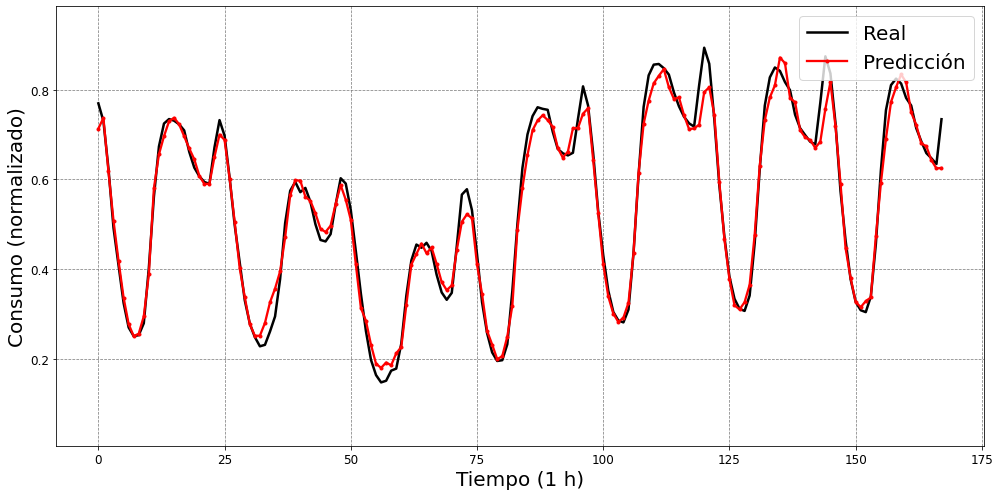

In [112]:
plot_real_vs_predicted(Y_test, modelo_recuperado.predict(X_test), x_limits = (24,24*8),
                      savefig = True, figname = "xgb_pred_test", formato = "png")

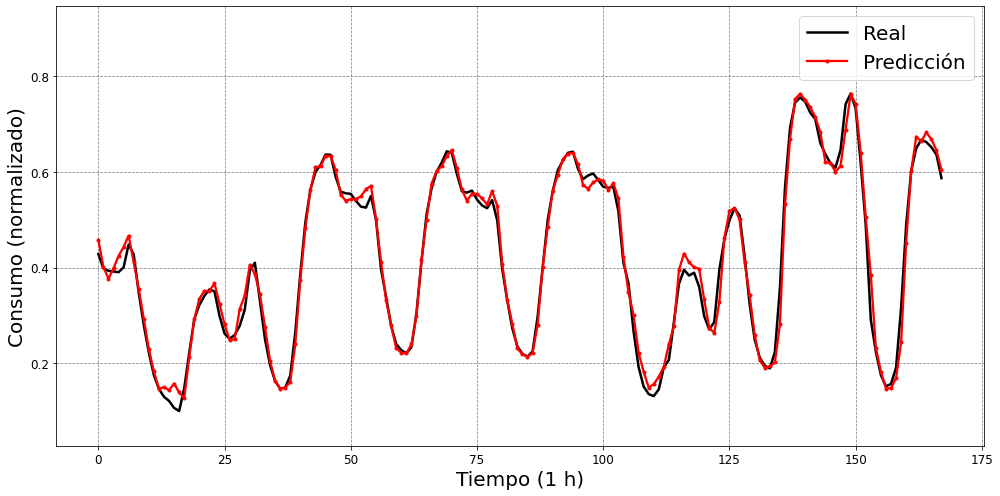

In [113]:
plot_real_vs_predicted(Y_val, modelo_recuperado.predict(X_val), x_limits = (24,24*8),
                      savefig = True, figname = "xgb_pred_val", formato = "png")

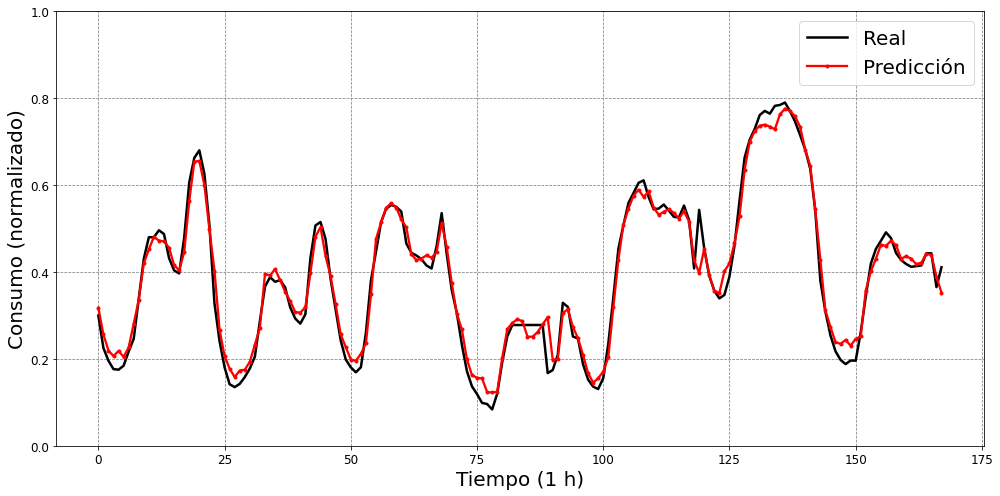

In [114]:
plot_real_vs_predicted(Y_train, modelo_recuperado.predict(X_train), x_limits = (24,24*8),
                      savefig = True, figname = "xgb_pred_train", formato = "png")